This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



### Preparation

In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"..\src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("✅ Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    


✅ Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


In [2]:
load_dotenv()  # loads .env file into environment

IBM_TOKEN = os.getenv("IBM_TOKEN")
CRN = os.getenv("CRN")

In [3]:

def service(ibm_token: str):
    """
    Connect to IBM Quantum service and list available backends.
    
    Parameters
    ----------
    ibm_token : str
        Your IBM Quantum API token.
    """
    backends =[]
    try:
        svc = QiskitRuntimeService(channel="ibm_quantum_platform", token=ibm_token)

        print("✅ Connected to IBM Quantum")
        print("Available backends:")
        for backend in svc.backends():
            print(f" - {backend.name}")
            backends.append(backend.name)
        return backends

    except Exception as e:
        print("❌ Failed to connect to IBM Quantum service.")
        print(f"Reason: {e}")
        return None
    

available_backends = service(IBM_TOKEN)
backend_name = available_backends[0]  # Select the first available backend

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-02 14:22:39,148: Default instance not set. Searching all available instances.


✅ Connected to IBM Quantum
Available backends:
 - ibm_brisbane
 - ibm_fez
 - ibm_torino
 - ibm_marrakesh


### Create Circuit

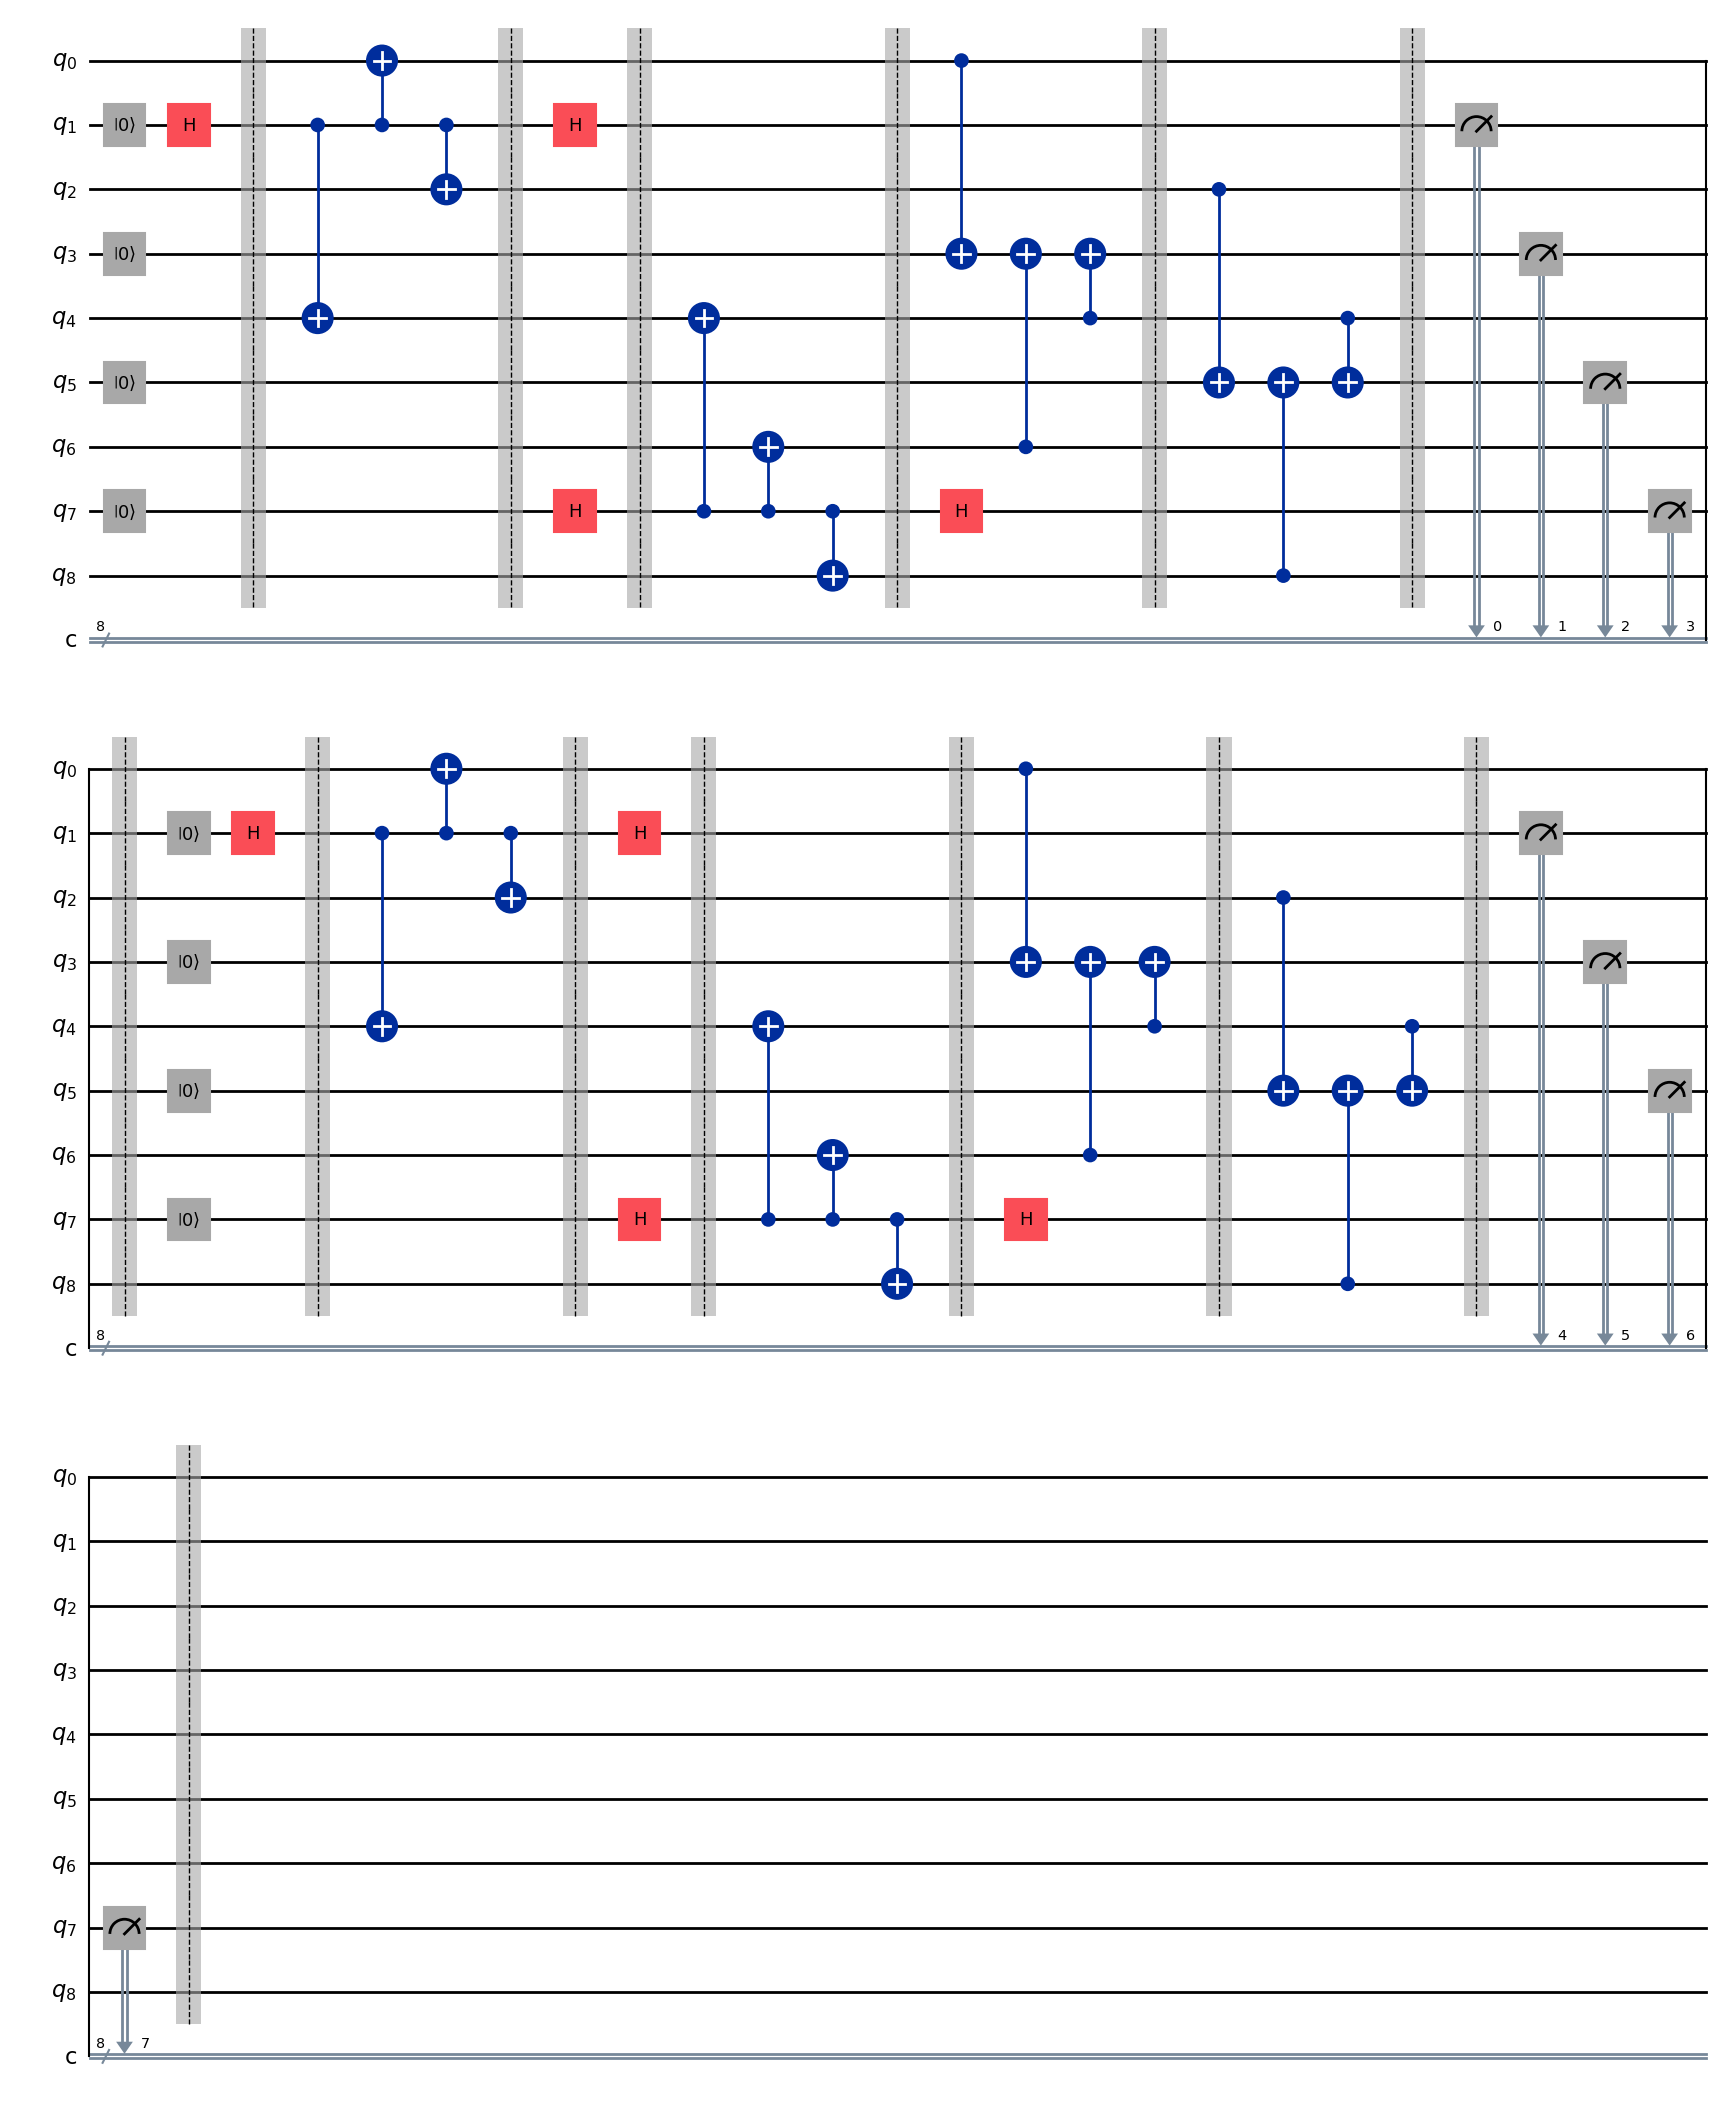

In [4]:
code = SurfaceCode(distance=2, cycles=2)
qc = code.qc
qc.draw("mpl")


In [5]:
print(code.n_data + code.n_stabilizers)



9


### Run

In [6]:

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

N = code.n_data + code.n_stabilizers# Number of qubits in the code
initial_psi = np.zeros(2**N)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N))  # logical qubit 0→physical 0, 1→1, etc.
shots = 1
bit_flip_bool = True

config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": backend_name,
        "crn": CRN
    },
    "run": {
        "shots": shots,
        "qubits_layout": initial_layout,
        "psi0": initial_psi
    }
}



In [7]:
backend_config = config["backend"]
backend = setup_backend(Token=IBM_TOKEN, **backend_config)
run_config = config["run"]

qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()



In [8]:

needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=N,
    bit_flip_bool=bit_flip_bool,
    )

counts = res["probs"]
results = res["results"]

No swaps detected in chunk
Reset on qubit:  1

No swaps detected in chunk
Reset on qubit:  3

No swaps detected in chunk
Reset on qubit:  5

No swaps detected in chunk
Reset on qubit:  7

No swaps detected in chunk
Reset on qubit:  0

No swaps detected in chunk
Reset on qubit:  3

No swaps detected in chunk
Reset on qubit:  5

No swaps detected in chunk
Reset on qubit:  8

No swaps detected in chunk
---- Preprocessed data ----
Chunk 0: delay[0]
Fancy 1: reset_qubits qubits=[1]
Chunk 2: rz[1] , sx[1] , rz[1] , delay[2]
Fancy 3: reset_qubits qubits=[3]
Chunk 4: delay[3] , delay[4]
Fancy 5: reset_qubits qubits=[5]
Chunk 6: delay[5] , delay[6]
Fancy 7: reset_qubits qubits=[7]
Chunk 8: delay[7] , delay[8] , rz[0] , sx[0] , rz[0] , delay[0] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , ecr[2, 1] , rz[1] , sx[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , delay[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , sx[1] , rz[1] , delay[1] , rz[2] , sx[2] , rz[2] , rz[3] , sx[3] , rz[3] , rz[4] , sx[

c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\_gates\factories.py:157: RuntimeWarning: invalid value encountered in sqrt
  ep = np.sqrt((1/2) * (e2**2 - e1**2/2))


ValueError: probabilities contain NaN

In [ ]:


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
print("Final measurement probabilities:", counts)

In [ ]:
print(shots)

10


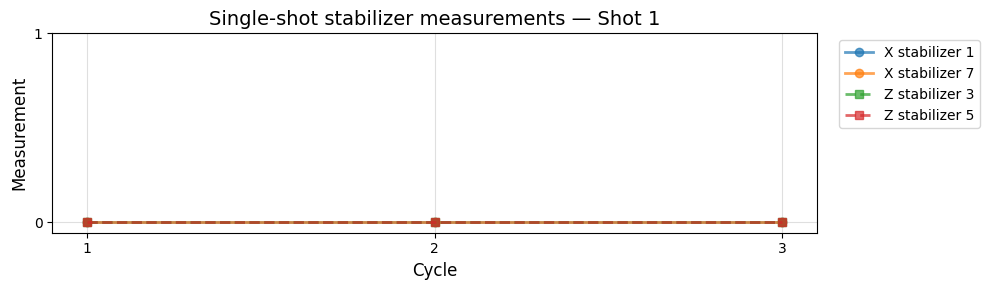

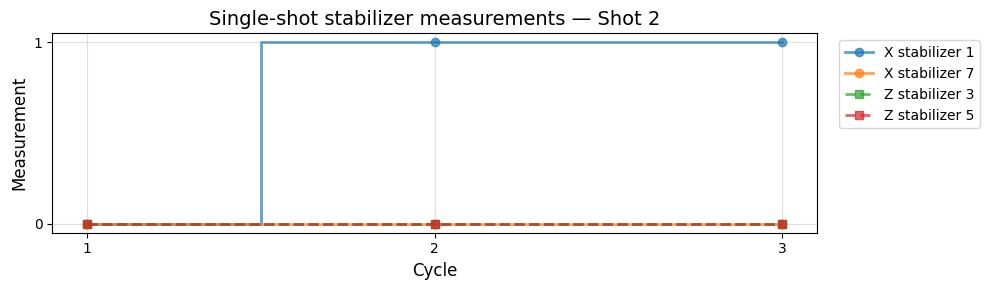

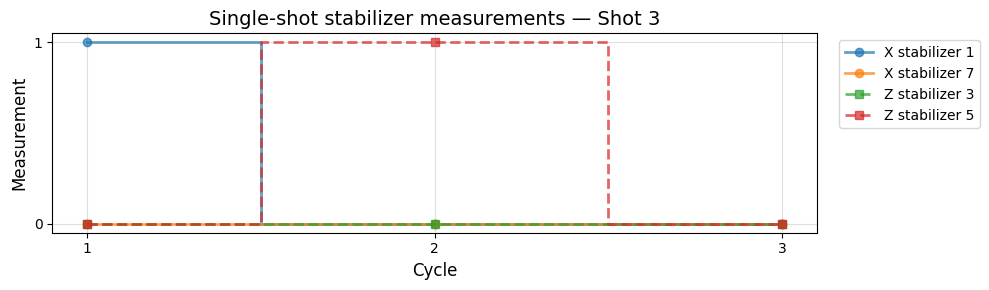

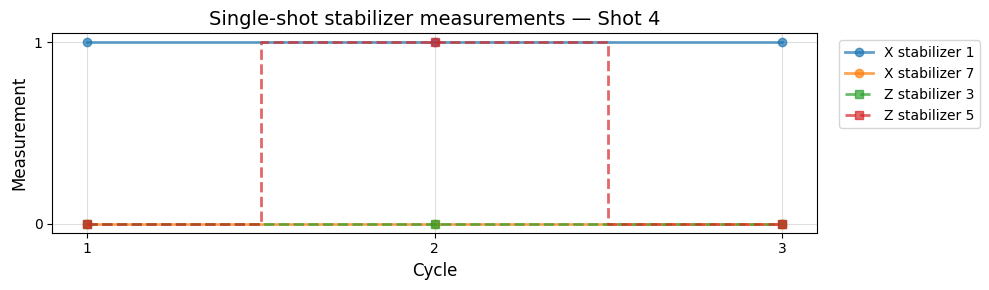

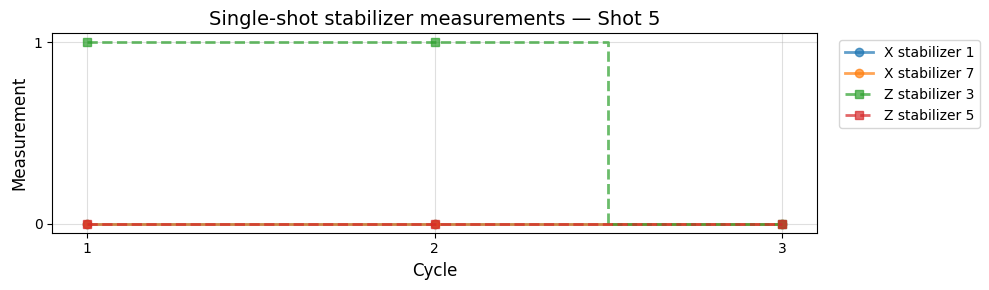

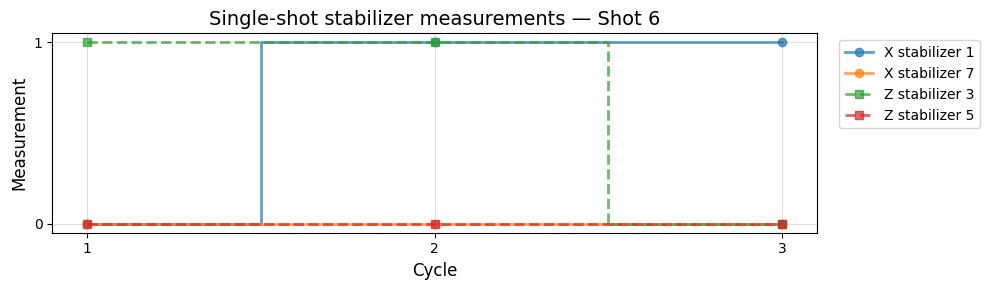

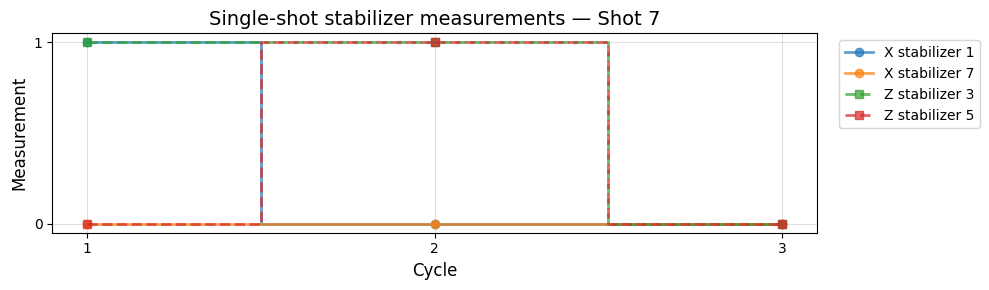

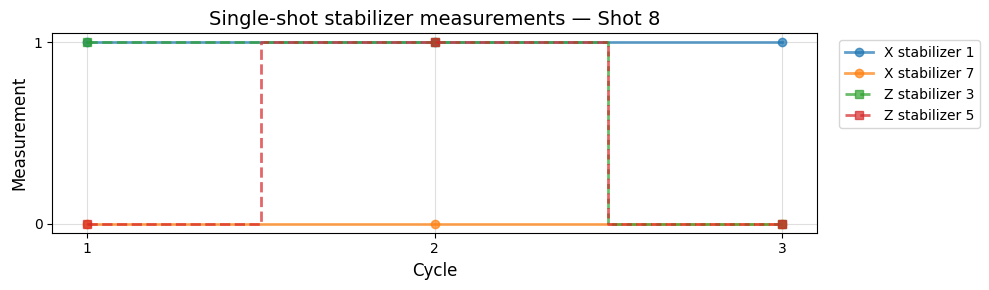

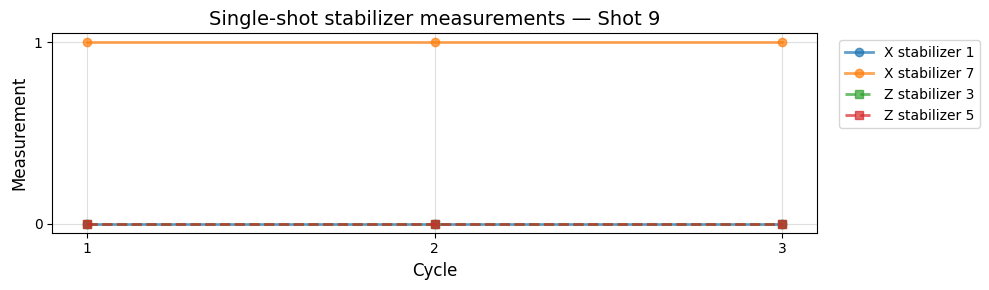

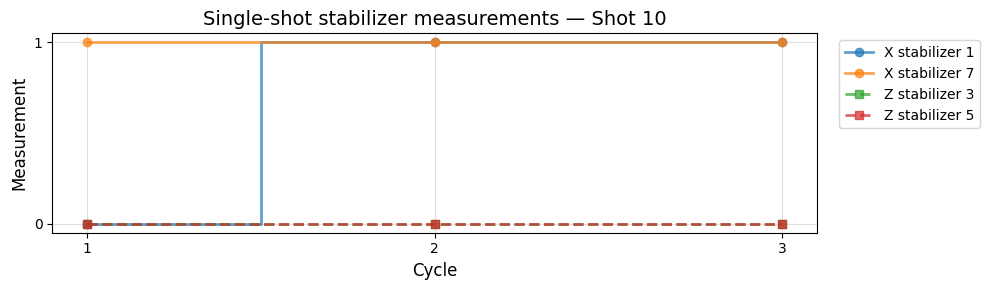

In [ ]:
code.plot_results(counts, shots, plot_each_shot=True)

